In [1]:
import pandas as pd
import numpy as np
import xarray as xr
# import all necessary libraries
import os
import warnings
from pathlib import Path

import cartopy.feature as cfeature
import geodatasets
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import xarray as xr
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from utils.eda_helper_functions import plot_histogram

from utils.eda_helper_functions import (
    check_missing_times,
    group_data_hourly,
    load_insitu_data,
    load_ocean_data,
    load_weather_data,
    plot_water_level_anomalies,
    process_df,
    process_flensburg_data,
    show_df,
)
from utils.config import (
    LAT_FLENSBURG,
    LON_FLENSBURG,
    SUB_BOX,
    OCEAN_DICT,
    WEATHER_DICT,
    INSITU_DICT,
    OCEAN_POINTS,
    WEATHER_POINTS,
    )

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns
#pd.options.display.max_columns = None






plt.rcParams.update({
    "font.size": 14,                # Grundschriftgröße (wirkt auf alles, sofern nicht überschrieben)
    "axes.titlesize": 16,           # Größe des Titels der Achse (z.B. 'Subplot Title')
    "axes.labelsize": 14,           # Achsenbeschriftung (x/y label)
    "xtick.labelsize": 12,          # X-Tick-Beschriftung
    "ytick.labelsize": 12,          # Y-Tick-Beschriftung
    "legend.fontsize": 12,          # Legendentext
    "figure.titlesize": 18,         # Gesamttitel der Abbildung (plt.suptitle)
    "figure.labelsize": 14,         # (optional, selten verwendet)
    "savefig.dpi": 300,             # DPI beim Speichern
    "figure.dpi": 100,              # DPI bei Anzeige
})


ocean_data_path = Path(f"../data/numerical_data/points{OCEAN_POINTS}")
print(ocean_data_path)
weather_data_path = Path(f"../data/numerical_data/points{WEATHER_POINTS}")
print(weather_data_path)

# save df_merged to ../data/tabular_data_FI/
file_name = f'df_merged{OCEAN_POINTS}_FI.tsv'
output_path = Path('../data/tabular_data_FI/')


../data/numerical_data/points5
../data/numerical_data/points10


In [3]:
df_ocean = load_ocean_data(ocean_data_path, OCEAN_POINTS, verbose=False)
df_ocean = process_df(df_ocean, drop_cols=["depth"], verbose=False)

df_weather = load_weather_data(weather_data_path, WEATHER_POINTS, verbose=False)
df_weather = process_df(df_weather, verbose=False, drop_cols=['showers'])

df_insitu = load_insitu_data(verbose=False)
df_insitu = process_flensburg_data(df_insitu, 
                                      start_time=df_ocean['time'].min(),
                                      end_time=df_ocean['time'].max(),
                                      verbose=False)

df_insitu = group_data_hourly(df_insitu)
df_insitu = process_df(df_insitu, drop_cols=["depth",'deph', 'latitude', 'longitude', 'time_qc', 'slev_qc'], verbose=False)


df_weather5.nc removed


In [5]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018400 entries, 0 to 2018399
Data columns (total 22 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   time                        datetime64[ns]
 1   latitude                    float32       
 2   longitude                   float32       
 3   temperature_2m              float32       
 4   relative_humidity_2m        float32       
 5   dew_point_2m                float32       
 6   apparent_temperature        float32       
 7   precipitation               float32       
 8   rain                        float32       
 9   snowfall                    float32       
 10  weather_code                float32       
 11  pressure_msl                float32       
 12  surface_pressure            float32       
 13  cloud_cover                 float32       
 14  cloud_cover_low             float32       
 15  cloud_cover_mid             float32       
 16  cloud_cover_high  

In [6]:
def feature_engineering(df_ocean, df_weather, df_insitu):
    """
    Funktion zur Berechnung der u- und v-Komponenten des Windes aus der Windgeschwindigkeit und -richtung.
    """
    
    # df_weather


    #Calculate Radial Wind Speed
    theta = np.deg2rad(df_weather['wind_direction_10m'])

    #Calculate u and v components
    #    Definition der u- und v-Komponenten:
    #    u = Windgeschwindigkeit * sin(Windrichtung)
    #    v = Windgeschwindigkeit * cos(Windrichtung)
    df_weather['wind_u'] = df_weather['wind_speed_10m'] * np.sin(theta)  # positiver Wert = Wind nach Osten
    df_weather['wind_v'] = df_weather['wind_speed_10m'] * np.cos(theta)  # positiver Wert = Wind nach Norden

    # Remove the original wind speed and direction columns
    df_weather.drop(columns=['wind_speed_10m', 'wind_direction_10m'], inplace=True)

    return df_ocean, df_weather, df_insitu


df_ocean, df_weather, df_insitu = feature_engineering(df_ocean, df_weather, df_insitu)

In [29]:
def convert_df_to_table(df: pd.DataFrame) -> pd.DataFrame:


    df['position'] = df.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
    coordinates = df['position'].unique()

    df_merged = pd.DataFrame({'time': df['time'].unique()})
    for i in tqdm(range(len(coordinates)), desc="Processing coordinates", unit="coord", total=len(coordinates)):

        df_sub_data = df[df['position'] == coordinates[i]]
        df_sub_data = df_sub_data.drop(columns=['latitude', 'longitude'])

        cols = df_sub_data.columns.tolist()
        cols.remove('position')
        cols.remove('time')


        for col in cols:
            df_sub_data.rename(columns={col: col + '#' + str(coordinates[i])}, inplace=True)

        df_sub_data = df_sub_data.drop(columns='position')


        df_merged = df_merged.merge(df_sub_data, on='time')
        
    return df_merged

In [8]:
df_ocean_table = convert_df_to_table(df_ocean)
df_weather_table = convert_df_to_table(df_weather)


Processing coordinates: 100%|██████████| 100/100 [00:15<00:00,  6.53coord/s]


In [9]:
print(f'\nShape of df_ocean before: {df_ocean.shape}')
print(f'Shape of df_ocean after: {df_ocean_table.shape}')
print(f'\nShape of df_weather before: {df_weather.shape}')
print(f'Shape of df_weather after: {df_weather_table.shape}')
print(f'\nShape of df_insitu before: {df_insitu.shape}')



Shape of df_ocean before: (221771, 15)
Shape of df_ocean after: (20161, 122)

Shape of df_weather before: (2018400, 23)
Shape of df_weather after: (20184, 1901)

Shape of df_insitu before: (20161, 2)


In [10]:
df_insitu

,time,slev
0,2022-12-03 00:00:00,0.487133
1,2022-12-03 01:00:00,0.463563
2,2022-12-03 02:00:00,0.373853
3,2022-12-03 03:00:00,0.285051
4,2022-12-03 04:00:00,0.238839
...,...,...
20156,2025-03-21 20:00:00,0.483333
20157,2025-03-21 21:00:00,0.496667
20158,2025-03-21 22:00:00,0.538333
20159,2025-03-21 23:00:00,0.550000


In [11]:
def merge_dataframes(dfs: list) -> pd.DataFrame:
    """
    Merge multiple DataFrames on the 'time' column.
    """
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on='time', how='inner')
    return merged_df


df_merged = merge_dataframes([df_ocean_table, df_weather_table, df_insitu])

In [12]:
df_merged.head()


,time,"bottomT#(55.12493133544922, 12.56934642791748)","mlotst#(55.12493133544922, 12.56934642791748)","siconc#(55.12493133544922, 12.56934642791748)","sithick#(55.12493133544922, 12.56934642791748)","sla#(55.12493133544922, 12.56934642791748)","so#(55.12493133544922, 12.56934642791748)","sob#(55.12493133544922, 12.56934642791748)","thetao#(55.12493133544922, 12.56934642791748)","uo#(55.12493133544922, 12.56934642791748)",...,"cloud_cover#(57.820735931396484, 16.753246307373047)","cloud_cover_low#(57.820735931396484, 16.753246307373047)","cloud_cover_mid#(57.820735931396484, 16.753246307373047)","cloud_cover_high#(57.820735931396484, 16.753246307373047)","et0_fao_evapotranspiration#(57.820735931396484, 16.753246307373047)","vapour_pressure_deficit#(57.820735931396484, 16.753246307373047)","wind_gusts_10m#(57.820735931396484, 16.753246307373047)","wind_u#(57.820735931396484, 16.753246307373047)","wind_v#(57.820735931396484, 16.753246307373047)",slev
0,2022-12-03 00:00:00,7.879676,14.649431,0.0,0.0,-0.086606,8.395580,9.989234,8.538280,-0.069994,...,100.0,100.0,87.0,0.0,0.039772,0.220712,37.439999,22.319973,21.240028,0.487133
1,2022-12-03 01:00:00,7.887771,14.657304,0.0,0.0,-0.074718,8.380219,9.974635,8.526820,-0.079356,...,100.0,100.0,35.0,0.0,0.034546,0.188996,43.919998,24.480024,22.319971,0.463563
2,2022-12-03 02:00:00,7.890751,16.498772,0.0,0.0,-0.053600,8.372637,9.964850,8.513932,-0.080955,...,100.0,100.0,2.0,33.0,0.044163,0.229348,44.639996,25.560038,22.319952,0.373853
3,2022-12-03 03:00:00,7.896270,16.501226,0.0,0.0,-0.050303,8.365764,9.951563,8.508351,-0.076369,...,100.0,100.0,0.0,15.0,0.042801,0.220077,45.719997,24.839966,24.120037,0.285051
4,2022-12-03 04:00:00,7.902933,16.500742,0.0,0.0,-0.050954,8.355705,9.934854,8.503732,-0.072867,...,100.0,100.0,0.0,89.0,0.043108,0.220807,45.719997,23.399984,25.560017,0.238839


In [14]:

df_merged.to_csv(output_path / file_name, index=False, sep='\t')

## Feature Importance

In [2]:
# Load data
df_merged = pd.read_csv(output_path / file_name, sep='\t')

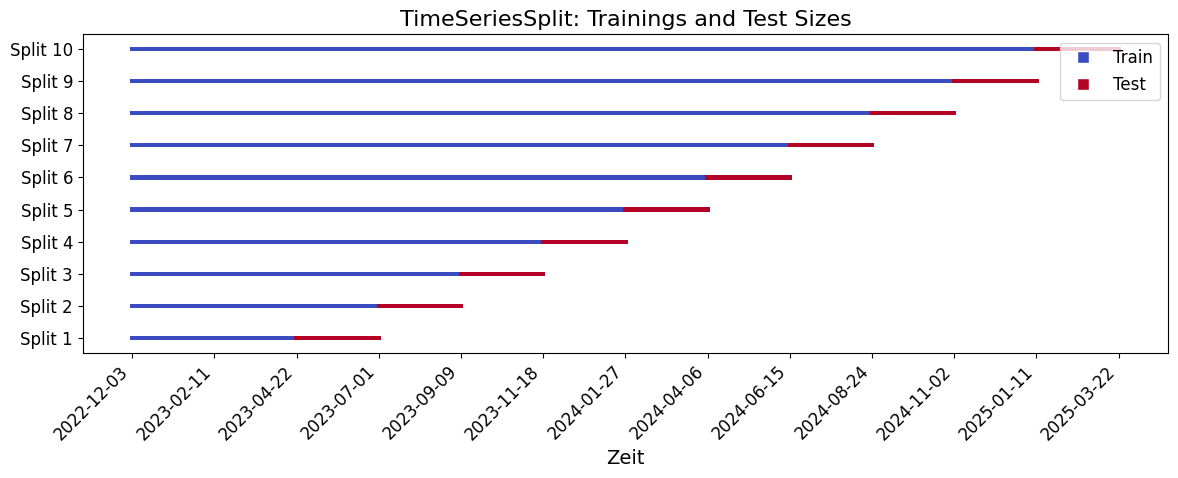

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

n_splits = 10
X = df_merged.drop(columns=["time", 'slev'])
times = pd.to_datetime(df_merged["time"]).dt.strftime('%Y-%m-%d').reset_index(drop=True)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=24*7*10)  # 7 Tage Testzeitraum, 24 Stunden pro Tag 

fig, ax = plt.subplots(figsize=(12, 5))
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    indices = np.full(len(X), np.nan)
    indices[train_index] = 0  # Trainingsdaten
    indices[test_index] = 1   # Testdaten
    ax.scatter(times, [i + 0.5] * len(X), c=indices, marker='s', cmap=plt.cm.coolwarm, lw=0, s=10)

ax.set_yticks(np.arange(n_splits) + 0.5)
ax.set_yticklabels([f"Split {i+1}" for i in range(n_splits)])
ax.set_xlabel("Zeit")
ax.set_title("TimeSeriesSplit: Trainings and Test Sizes")

# X-Ticks reduzieren
max_xticks = 12  # z.B. 12 Ticks für Übersichtlichkeit
step = max(1, len(times) // max_xticks)
ax.set_xticks(times[::step])
ax.set_xticklabels(times[::step], rotation=45, ha='right')

ax.legend([plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.coolwarm(0.), markersize=8, label='Train'),
           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.coolwarm(1.), markersize=8, label='Test')],
          ['Train', 'Test'], loc='upper right')
plt.tight_layout()
plt.show()

In [5]:

## Hyperparameter-Tuning für RandomForestRegressor mit TimeSeriesSplit und Optuna


import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# Features und Zielvariable
X = df_merged.drop(columns=["time", "slev"])
y = df_merged["slev"]



def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
        "n_jobs": -1
    }
    model = RandomForestRegressor(**params)
    scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_mean_squared_error", n_jobs=-1)
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("Beste Hyperparameter:", study.best_params)
print("Bestes (negatives) MSE:", study.best_value)



[I 2025-05-25 13:34:20,118] A new study created in memory with name: no-name-ce55064e-2863-40b7-9c67-21a8fbfb8367
[I 2025-05-25 13:34:28,503] Trial 0 finished with value: -0.04551119829330292 and parameters: {'n_estimators': 92, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: -0.04551119829330292.
[I 2025-05-25 13:34:53,114] Trial 1 finished with value: -0.033733276073241954 and parameters: {'n_estimators': 133, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: -0.033733276073241954.
[I 2025-05-25 13:35:26,687] Trial 2 finished with value: -0.038017780170222684 and parameters: {'n_estimators': 282, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: -0.033733276073241954.
[I 2025-05-25 13:35:44,175] Trial 3 finished with value: 

Beste Hyperparameter: {'n_estimators': 180, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}
Bestes (negatives) MSE: -0.02958154413801527


### Optuna Visualisierungen: Optimierungsverlauf und Hyperparameter-Importanz

In [6]:
import optuna.visualization as vis

# Verlauf der Optimierung (Zielwert pro Trial)
fig1 = vis.plot_optimization_history(study)
fig1.show()

# Wichtigkeit der Hyperparameter
fig2 = vis.plot_param_importances(study)
fig2.show()


fig4 = vis.plot_parallel_coordinate(study)
fig4.show()

## Evaluate Best Model

In [10]:
# Trainiere das finale Modell mit den besten Parametern
best_rf = RandomForestRegressor(**study.best_params)
# scoring = RMSE
scoring = "neg_root_mean_squared_error"

scores = cross_val_score(best_rf, X, y, cv=tscv, scoring=scoring, n_jobs=-1)

print("Finales (negatives) RMSE:", np.mean(scores))
print("Final Model Std:", np.std(scores))



Finales (negatives) RMSE: -0.16240802503608812
Final Model Std: 0.05288031326206492


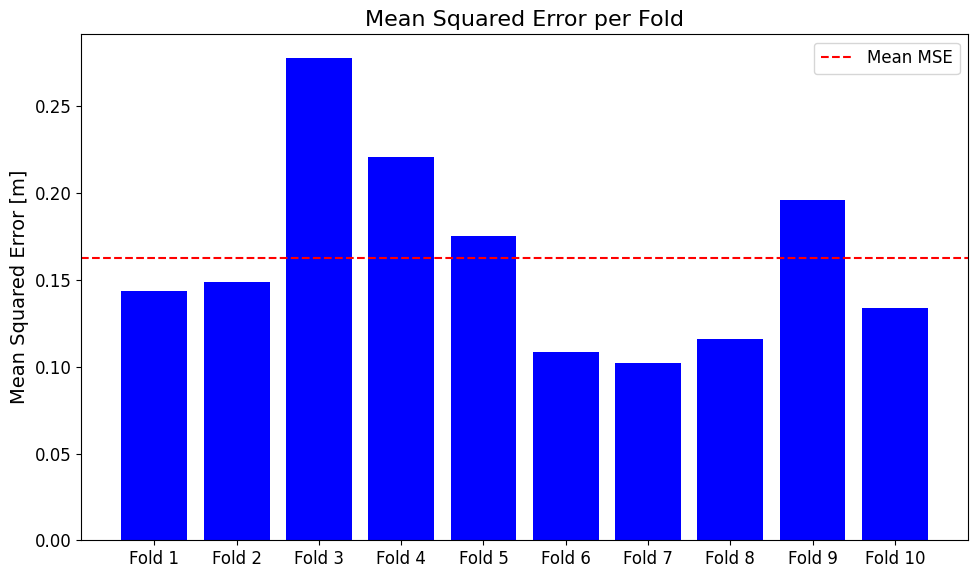

In [ ]:
# Barchart für die scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(scores)), -scores, color='blue', capsize=5)
plt.ylabel("Root Mean Squared Error [m]")
plt.title("Root Mean Squared Error per Fold")
plt.xticks(range(len(scores)), [f"Split {i+1}" for i in range(len(scores))])
plt.axhline(y=-np.mean(scores), color='r', linestyle='--', label='Mean RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Visualize Feature Importance

In [7]:
feature_importances = best_rf.feature_importances_
# to dataframe

feature_importances_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

feature_importances_df.reset_index(drop=True, inplace=True)

display(feature_importances_df)


feature_importances_df['location'] = feature_importances_df['feature'].apply(lambda x: x.split('#')[-1])
feature_importances_df['latitude'] = feature_importances_df['location'].apply(lambda x: x.split(',')[0].strip('('))
feature_importances_df['longitude'] = feature_importances_df['location'].apply(lambda x: x.split(',')[1].strip(')'))
feature_importances_df['feature'] = feature_importances_df['feature'].apply(lambda x: x.split('#')[0])
# Nur den eigentlichen Feature-Namen extrahieren (alles vor dem letzten "_(")
# convert to float
feature_importances_df['latitude'] = feature_importances_df['latitude'].astype(float)
feature_importances_df['longitude'] = feature_importances_df['longitude'].astype(float)

feature_importances_df

,feature,importance
0,"sla#(55.12493133544922, 12.56934642791748)",0.041002
1,"wind_u#(55.641475677490234, 10.588234901428223)",0.025858
2,"sla#(55.12493133544922, 16.04155731201172)",0.021853
3,"wind_u#(54.9384880065918, 12.166997909545898)",0.021196
4,"wind_u#(56.41476058959961, 10.64315414428711)",0.018965
...,...,...
2016,"snowfall#(53.53251266479492, 15.315486907958984)",0.000000
2017,"snowfall#(57.820735931396484, 18.506492614746094)",0.000000
2018,"snowfall#(57.820735931396484, 21.428571701049805)",0.000000
2019,"snowfall#(53.53251266479492, 18.413002014160156)",0.000000


,feature,importance,location,latitude,longitude
0,sla,0.041002,"(55.12493133544922, 12.56934642791748)",55.124931,12.569346
1,wind_u,0.025858,"(55.641475677490234, 10.588234901428223)",55.641476,10.588235
2,sla,0.021853,"(55.12493133544922, 16.04155731201172)",55.124931,16.041557
3,wind_u,0.021196,"(54.9384880065918, 12.166997909545898)",54.938488,12.166998
4,wind_u,0.018965,"(56.41476058959961, 10.64315414428711)",56.414761,10.643154
...,...,...,...,...,...
2016,snowfall,0.000000,"(53.53251266479492, 15.315486907958984)",53.532513,15.315487
2017,snowfall,0.000000,"(57.820735931396484, 18.506492614746094)",57.820736,18.506493
2018,snowfall,0.000000,"(57.820735931396484, 21.428571701049805)",57.820736,21.428572
2019,snowfall,0.000000,"(53.53251266479492, 18.413002014160156)",53.532513,18.413002


In [8]:
# groupby feature and sum importance
feature_importances_grouped = feature_importances_df.groupby('feature').agg({'importance': 'sum'}).reset_index().sort_values(by='importance', ascending=True)

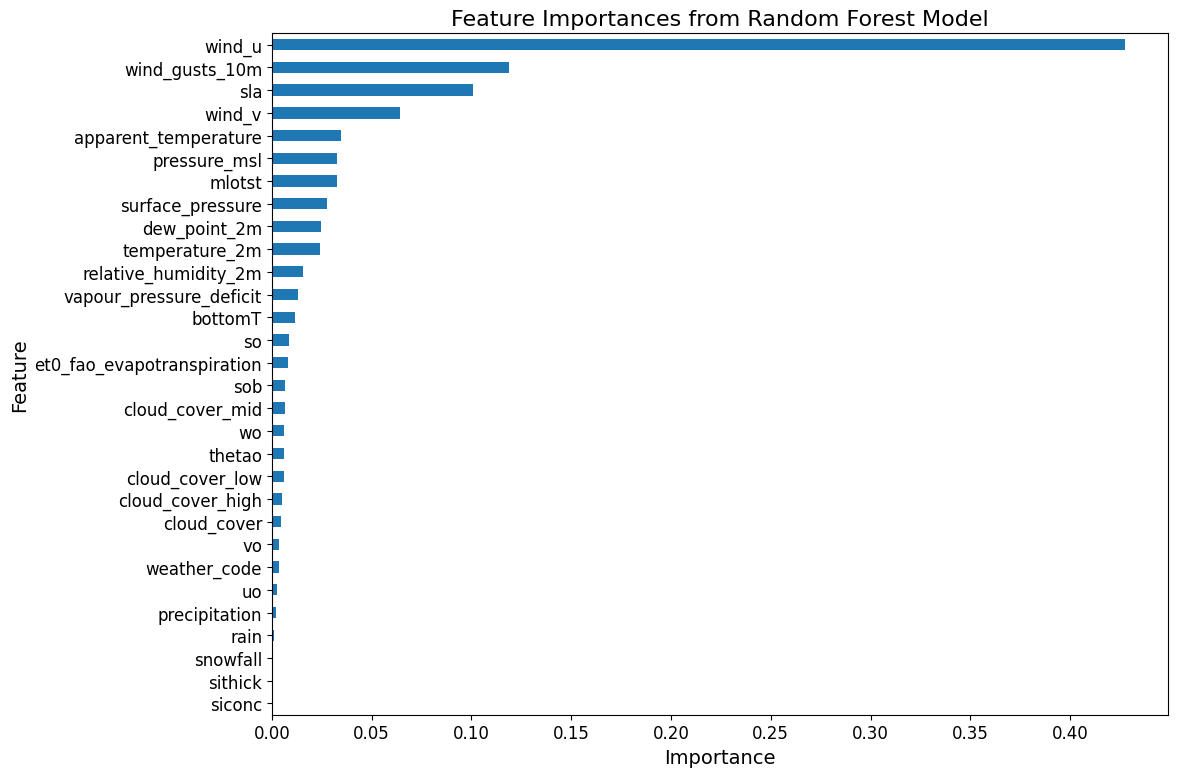

In [9]:
# Barchart der Feature-Wichtigkeiten
plt.figure(figsize=(12, 8))
feature_importances_grouped.plot(kind='barh', x='feature', y='importance', ax=plt.gca(), legend=False)
plt.title("Feature Importances from Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()

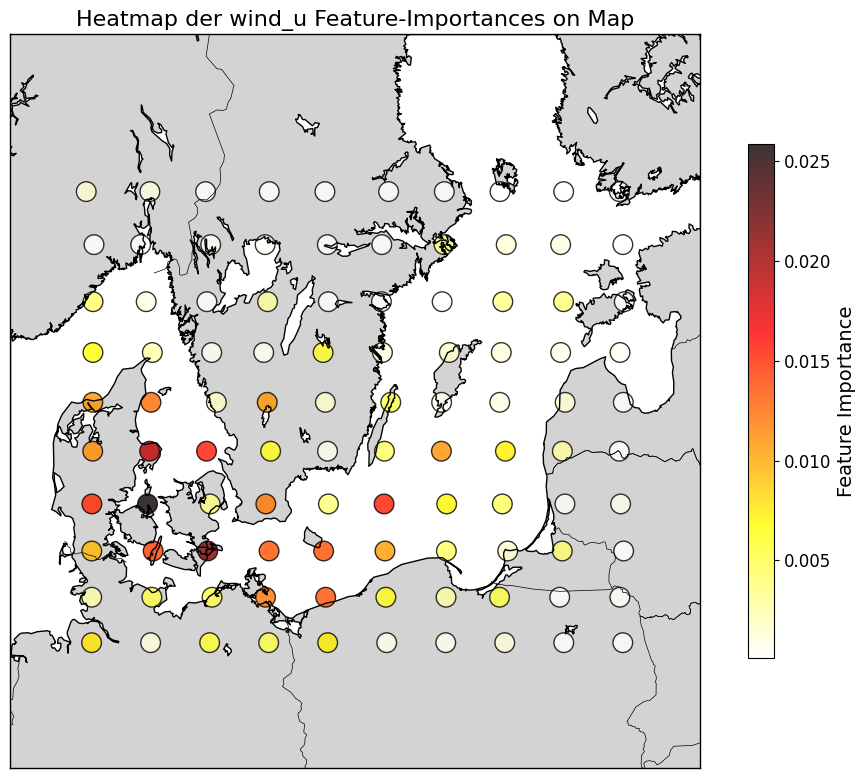

In [19]:

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def plot_feature_importance_heatmap(df: pd.DataFrame, feature:str):

    df = df[df['feature'] == feature]

    plt.figure(figsize=(10, 8))
    m = Basemap(
        projection='merc',
        llcrnrlat=df['latitude'].min() - 2,
        urcrnrlat=df['latitude'].max() + 2,
        llcrnrlon=df['longitude'].min() - 2,
        urcrnrlon=df['longitude'].max() + 2,
        resolution='i'
    )
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='white')
    m.fillcontinents(color='lightgray', lake_color='white')

    # Punkte in Karten-Koordinaten umrechnen
    x, y = m(df['longitude'].values, df['latitude'].values)

    # Heatmap: Streudiagramm mit Farbe nach Importance
    sc = m.scatter(x, y, c=df['importance'], cmap='hot_r', s=200, edgecolor='k', alpha=0.8)
    cbar = plt.colorbar(sc, shrink=0.7, pad=0.05)
    cbar.set_label('Feature Importance')
    plt.title(f'Heatmap der {feature} Feature-Importances on Map')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(feature_importances_df, feature='wind_u')



In [ ]:
plot_feature_importance_heatmap(feature_importances_df, feature='wind_u')

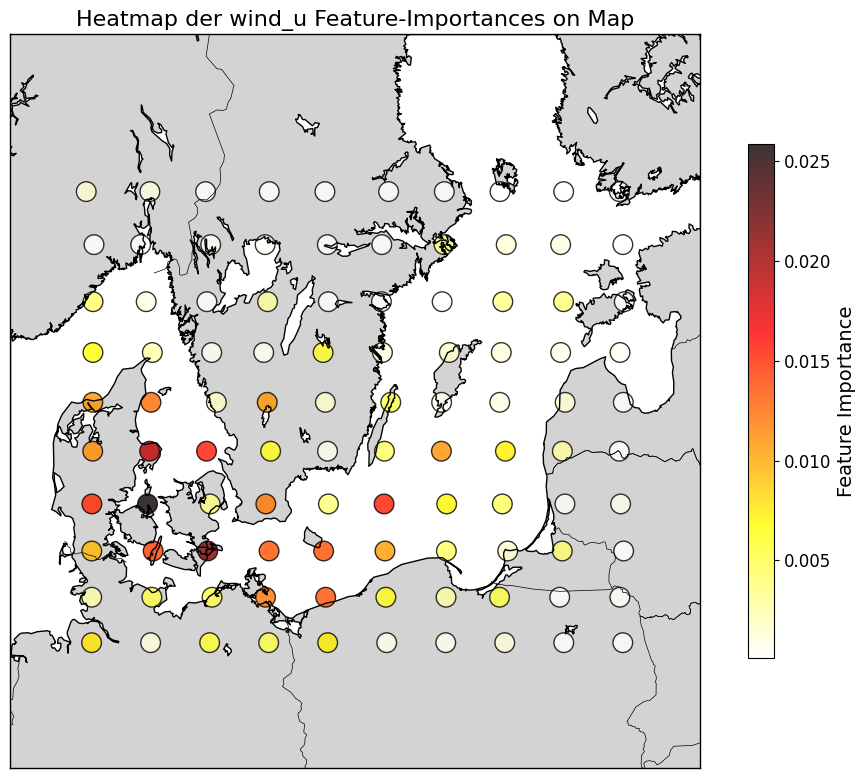

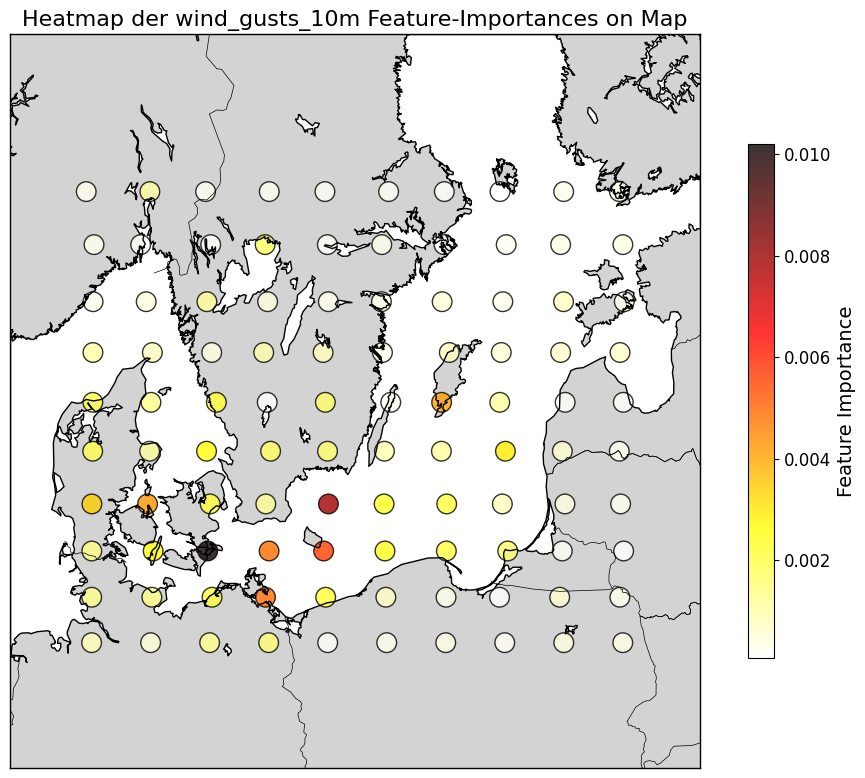

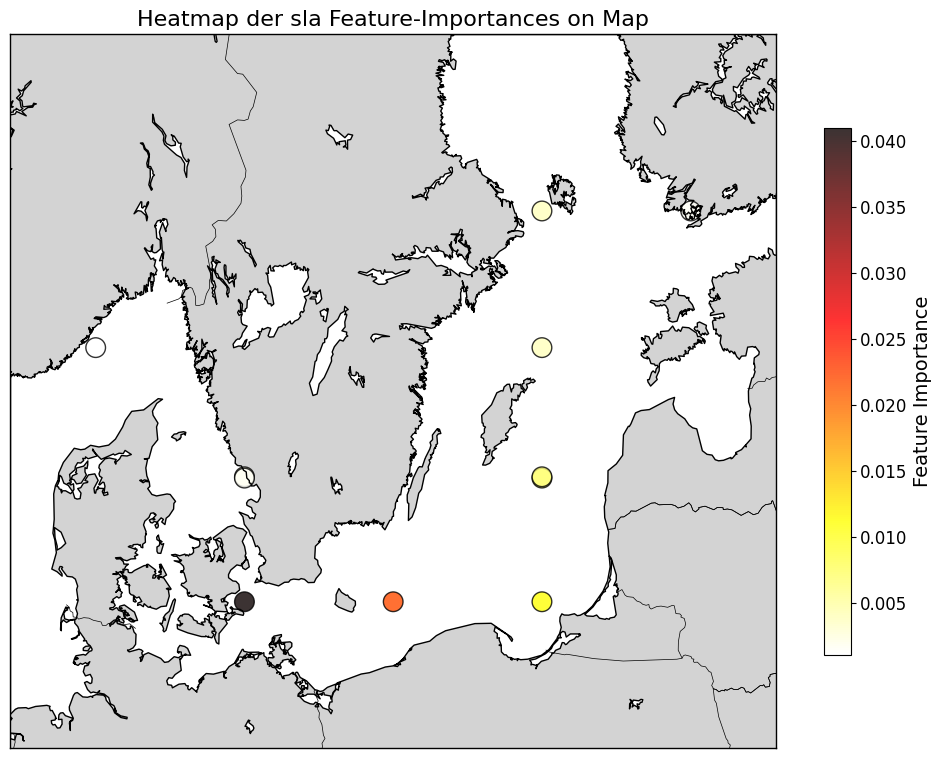

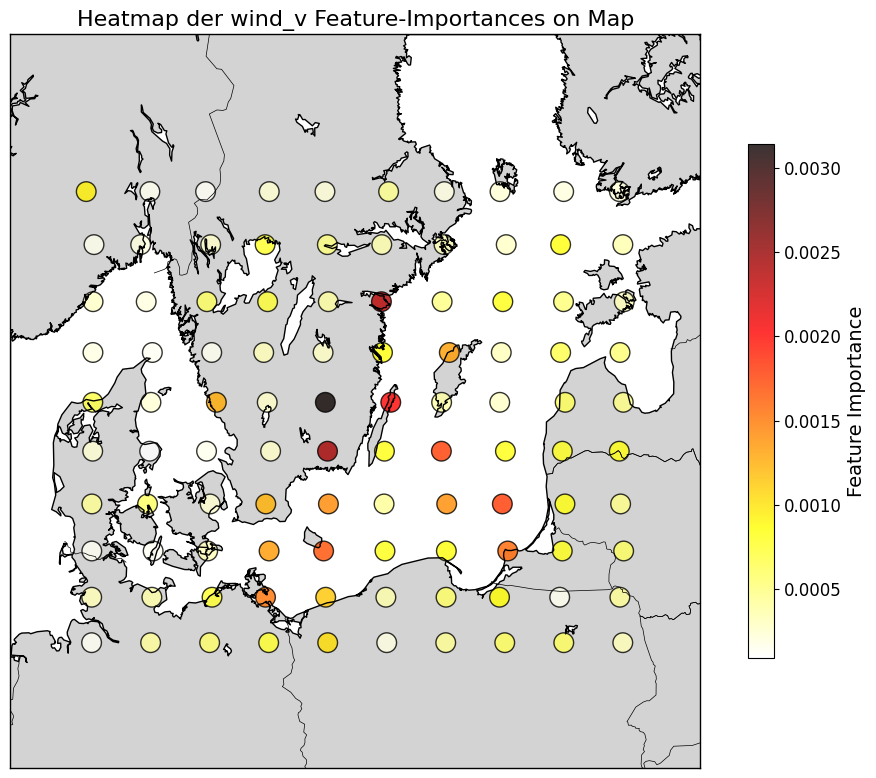

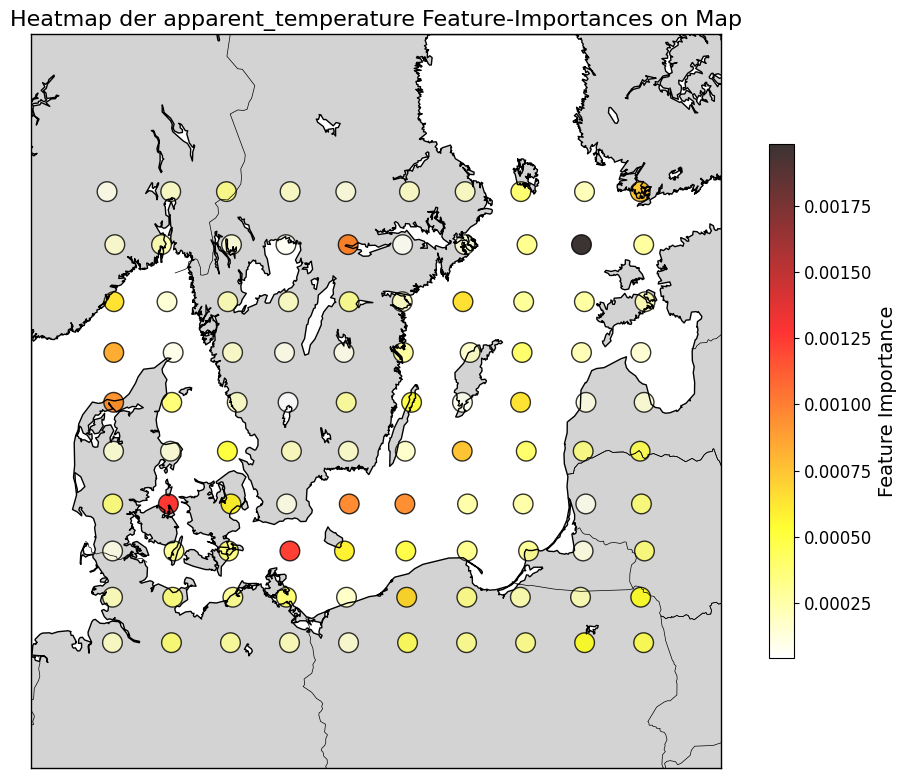

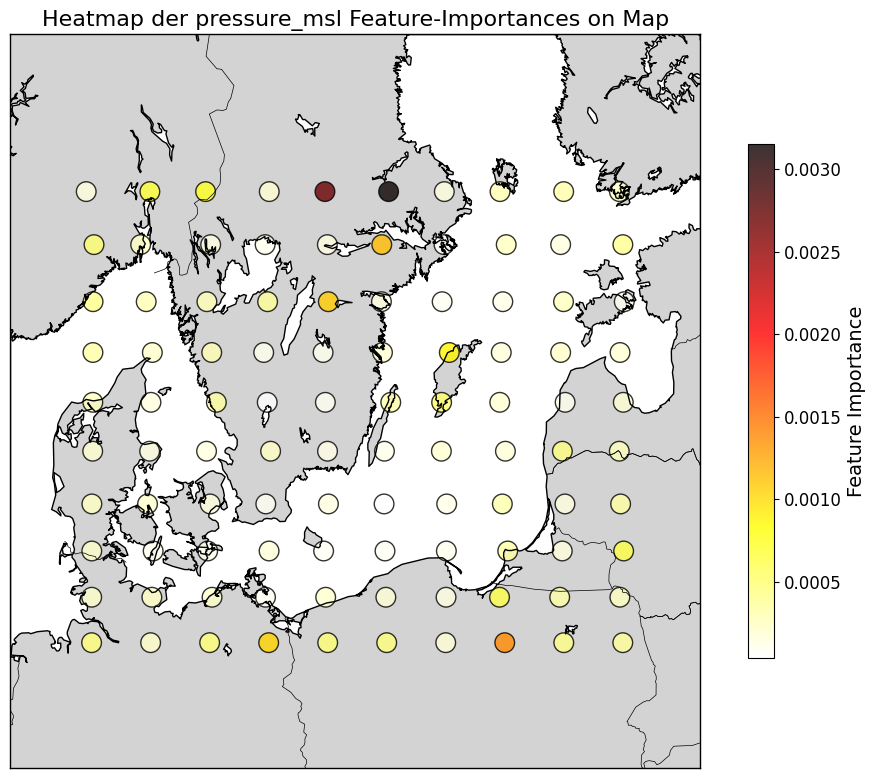

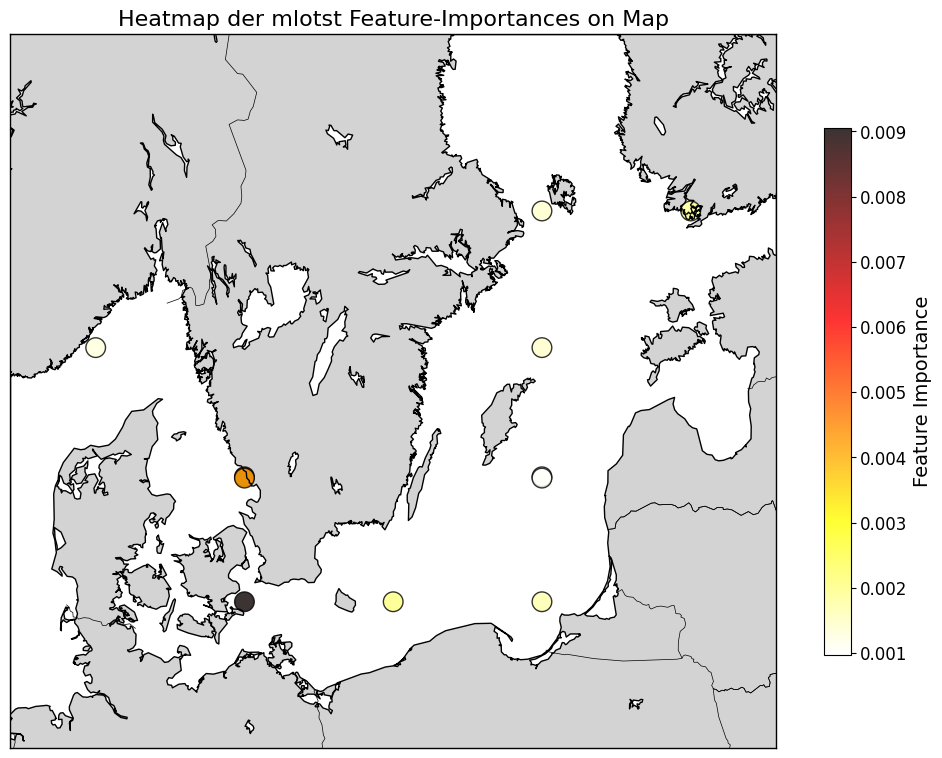

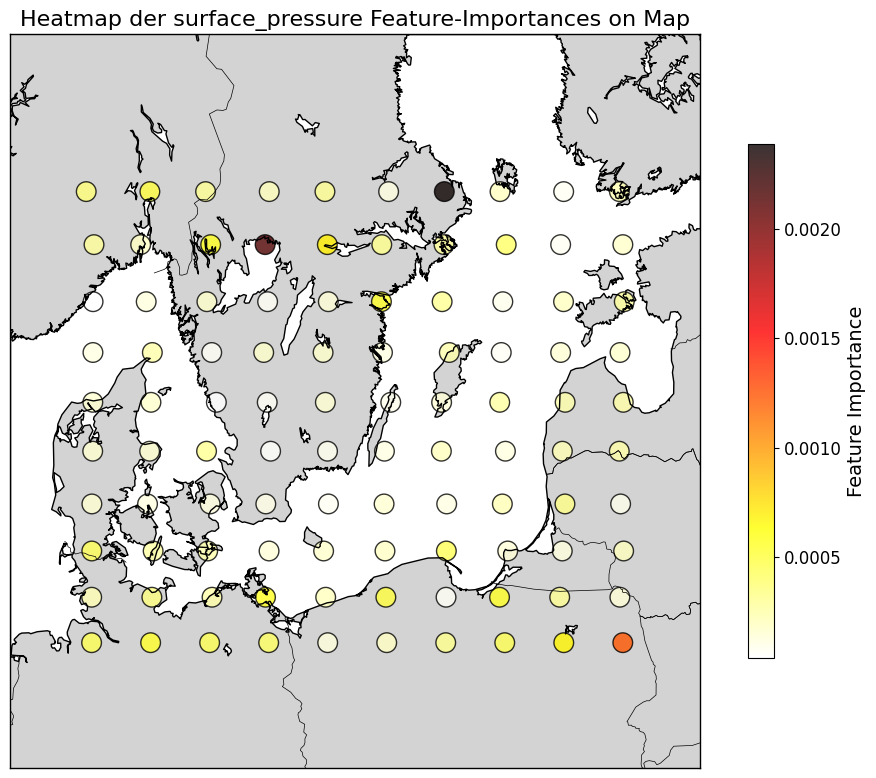

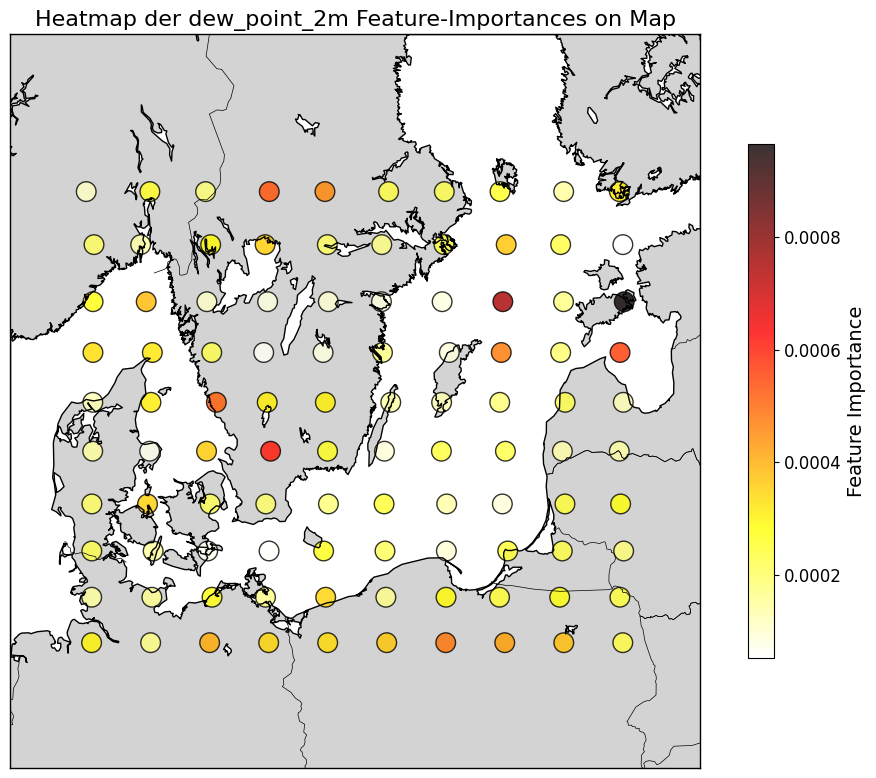

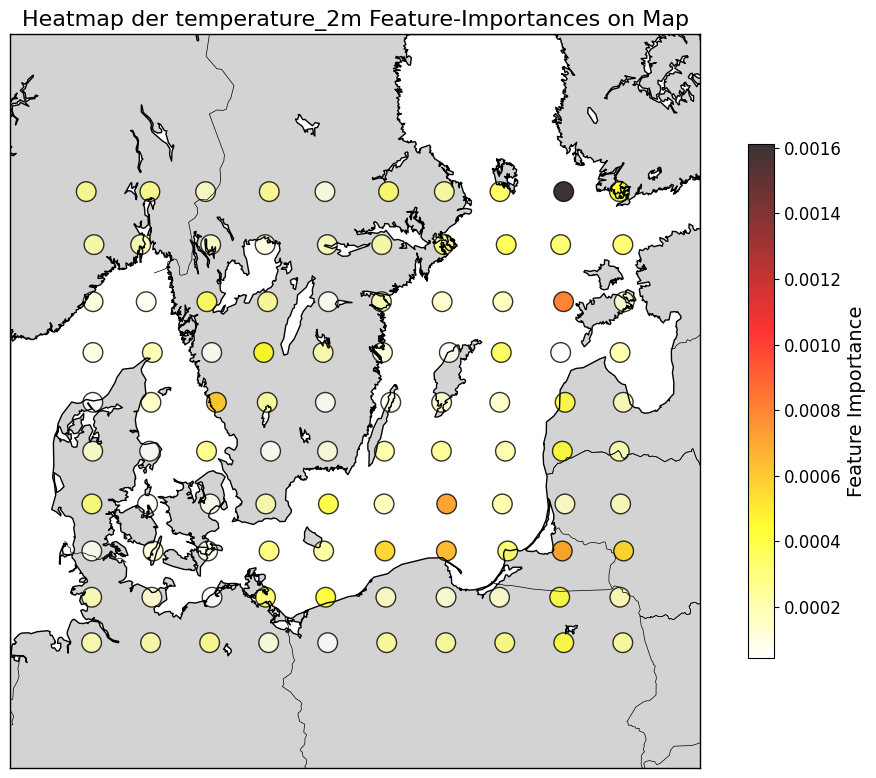

In [20]:
features = feature_importances_grouped.nlargest(10, 'importance')['feature'].tolist()

for feature in features:
    plot_feature_importance_heatmap(feature_importances_df, feature=feature)


# Archive

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def time_series_split_eval(model=RandomForestRegressor(), X=None, y=None, n_splits=2, verbose=False):
    """
    Perform time series cross-validation and evaluate the model.
    """
    # 3) TimeSeriesSplit konfigurieren
    
    tscv = TimeSeriesSplit(n_splits=n_splits)


    # 5) Cross-Validation laufen lassen and MSE pro Fold berechnen
    mse_scores = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Modell fitten
        model.fit(X_train, y_train)
        # Vorhersage
        y_pred = model.predict(X_test)
        # MSE berechnen
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)


    if verbose:
        print("\nMSE pro Fold:")
        for fold, mse in enumerate(mse_scores, 1):
            print(f"Fold {fold}: MSE = {mse:.4f}")
        # 6) Durchschnittlichen MSE berechnen
        print("\nDurchschnittlicher MSE über alle Folds: "
            f"{np.mean(mse_scores):.4f}")

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1) Daten erzeugen: ein einfaches, univariates Zeit­reihen­signal
np.random.seed(42)
n_samples = 100
time = np.arange(n_samples)
# Trend + Rauschen
y = 0.05 * time + np.sin(time / 5) + np.random.normal(scale=0.5, size=n_samples)

# In ein DataFrame packen (optional, aber oft praktisch)
df = pd.DataFrame({'t': time, 'y': y})

# 2) Merkmals-Matrix X und Ziel y definieren
#    Hier nur die Zeitindizes als Feature – in der Praxis nutzt du natürlich mehr
X = df[['t']].values
y = df['y'].values

time_series_split_eval(
    model=LinearRegression(),
    X=X,
    y=y,
    n_splits=2,
    verbose=True
)



MSE pro Fold:
Fold 1: MSE = 4.1204
Fold 2: MSE = 1.0828

Durchschnittlicher MSE über alle Folds: 2.6016


In [ ]:
dd

In [ ]:
import pandas as pd
import numpy as np


def generate_random_ocean_data():
    # Zeitstempel generieren (stündlich von 2023-01-01 bis 2025-03-01)
    time_index = pd.date_range(start="2023-01-01", end="2025-03-01", freq="H")

    # Beispiel-Koordinaten (Breitengrad, Längengrad)
    coordinates = [
        (54.32, 10.14),  # Kiel, Deutschland
        (60.39, 5.32),   # Bergen, Norwegen
        (36.85, -6.27),  # Cádiz, Spanien
        (-33.87, 151.21) # Sydney, Australien
    ]

    # Funktion zur Generierung realistischer Ozeandaten mit saisonalen Schwankungen
    def generate_ocean_data(time_index):
        n = len(time_index)
        t = np.arange(n)

        # Jahreszeitliche Schwankungen simulieren (Sinus-Funktion)
        seasonality = np.sin(2 * np.pi * t / (24 * 365))  # Jahresperiode

        # Wassertemperatur (°C) mit saisonalen Schwankungen
        water_temp = 10 + 5 * seasonality + np.random.normal(0, 1, n)

        # Wasserhöhe (m) mit zufälligen Schwankungen (Gezeiten)
        water_height = 1.5 + 0.5 * np.sin(2 * np.pi * t / (12)) + np.random.normal(0, 0.2, n)

        # Windgeschwindigkeit (m/s) mit variablen Böen
        wind_speed = 5 + 2 * np.cos(2 * np.pi * t / (24 * 7)) + np.random.normal(0, 1, n)

        return water_temp, water_height, wind_speed

    # DataFrame erstellen
    data = []

    for lat, lon in coordinates:
        water_temp, water_height, wind_speed = generate_ocean_data(time_index)
        df = pd.DataFrame({
            "timestamp": time_index,
            "latitude": lat,
            "longitude": lon,
            "water_temperature": water_temp,
            "water_height": water_height,
            "wind_speed": wind_speed
        })
        data.append(df)

    # Alle Daten zusammenführen
    ocean_data = pd.concat(data, ignore_index=True)
    return ocean_data


In [ ]:
#ocean_data = df.copy()
# Erstellen der 'position'-Spalte als Tupel aus 'latitude' und 'longitude'
ocean_data['position'] = ocean_data.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
ocean_data.rename(columns={'timestamp': 'time'}, inplace=True)
ocean_data

,time,latitude,longitude,water_temperature,water_height,wind_speed,position
0,2023-01-01 00:00:00,54.32,10.14,10.972316,1.663210,6.960804,"(54.32, 10.14)"
1,2023-01-01 01:00:00,54.32,10.14,10.509522,1.780243,5.789207,"(54.32, 10.14)"
2,2023-01-01 02:00:00,54.32,10.14,12.063690,1.601395,7.223601,"(54.32, 10.14)"
3,2023-01-01 03:00:00,54.32,10.14,11.317991,1.959013,7.465377,"(54.32, 10.14)"
4,2023-01-01 04:00:00,54.32,10.14,8.554298,1.791218,6.529779,"(54.32, 10.14)"
...,...,...,...,...,...,...,...
75839,2025-02-28 20:00:00,-33.87,151.21,15.726693,1.301309,7.039045,"(-33.87, 151.21)"
75840,2025-02-28 21:00:00,-33.87,151.21,12.794479,1.102870,6.224526,"(-33.87, 151.21)"
75841,2025-02-28 22:00:00,-33.87,151.21,15.849361,1.334013,6.205082,"(-33.87, 151.21)"
75842,2025-02-28 23:00:00,-33.87,151.21,14.123349,0.980426,4.052394,"(-33.87, 151.21)"


In [ ]:
coordinates = ocean_data['position'].unique()
print(len(coordinates))  # Anzahl der einzigartigen Koordinaten
coordinates

4


array([(54.32, 10.14), (60.39, 5.32), (36.85, -6.27), (-33.87, 151.21)],
      dtype=object)

In [ ]:
df_merged = pd.DataFrame({'time': ocean_data['time'].unique()})

for i in range(len(coordinates)):

    ocean_sub_data = ocean_data.loc[ocean_data['position'] == coordinates[i]]

    ocean_sub_data = ocean_sub_data.drop(columns=['latitude', 'longitude'])
   # display(ocean_sub_data)
    cols = ocean_sub_data.columns.to_list()

    cols.remove('time')
    cols.remove('position')

    

    for col in cols:
        ocean_sub_data.rename(columns={col: col + '_' + str(coordinates[i])}, inplace=True)

    ocean_sub_data = ocean_sub_data.drop(columns='position')


    df_merged = df_merged.merge(ocean_sub_data, on='time')
display(df_merged)
    
    

,time,"water_temperature_(54.32, 10.14)","water_height_(54.32, 10.14)","wind_speed_(54.32, 10.14)","water_temperature_(60.39, 5.32)","water_height_(60.39, 5.32)","wind_speed_(60.39, 5.32)","water_temperature_(36.85, -6.27)","water_height_(36.85, -6.27)","wind_speed_(36.85, -6.27)","water_temperature_(-33.87, 151.21)","water_height_(-33.87, 151.21)","wind_speed_(-33.87, 151.21)"
0,2023-01-01 00:00:00,10.972316,1.663210,6.960804,9.866102,1.379971,7.766973,8.377738,1.881771,8.363421,7.878631,1.487266,7.970692
1,2023-01-01 01:00:00,10.509522,1.780243,5.789207,10.160645,1.595812,7.812240,10.566244,1.947198,6.947956,8.931731,1.936149,8.078456
2,2023-01-01 02:00:00,12.063690,1.601395,7.223601,10.138654,1.538970,6.810172,8.375085,1.847475,5.967973,10.447721,2.037425,6.013923
3,2023-01-01 03:00:00,11.317991,1.959013,7.465377,9.032991,1.683790,7.711469,9.286906,2.008942,8.782281,8.089932,2.149767,5.043736
4,2023-01-01 04:00:00,8.554298,1.791218,6.529779,9.913152,1.802192,5.665398,9.306040,1.570702,6.986051,11.289963,1.770368,8.314881
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18956,2025-02-28 20:00:00,13.619330,1.366424,5.158142,14.356171,0.954532,5.353912,12.656578,0.949468,5.499188,15.726693,1.301309,7.039045
18957,2025-02-28 21:00:00,15.032880,0.853618,5.096853,14.856987,1.057077,5.175403,13.893649,1.148721,6.676825,12.794479,1.102870,6.224526
18958,2025-02-28 22:00:00,14.766122,1.125011,5.455343,13.017925,0.923525,4.807538,15.801969,0.803954,7.493099,15.849361,1.334013,6.205082
18959,2025-02-28 23:00:00,13.354829,1.183887,5.947385,15.271190,1.285391,5.340879,13.111832,1.001787,5.382073,14.123349,0.980426,4.052394


In [ ]:
# Hier weiter machene, group by hour

In [ ]:
target_file = 'data/NO_TS_TG_KielHoltenauTG.nc'
ds = xr.open_dataset(target_file)
df_target = ds.to_dataframe()
df_target = df_target.reset_index()
df_target

,TIME,DEPTH,TIME_QC,DEPH,LATITUDE,LONGITUDE,STATION,SLEV,SLEV_QC
0,2014-01-19 06:00:00.000000000,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',0.520,1.0
1,2014-01-19 06:10:00.000000000,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',0.520,1.0
2,2014-01-19 06:20:00.000000256,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',0.530,1.0
3,2014-01-19 06:30:00.000000000,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',0.530,1.0
4,2014-01-19 06:40:00.000000000,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',0.530,1.0
...,...,...,...,...,...,...,...,...,...
1018864,2025-02-28 23:10:00.000000000,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',-0.027,1.0
1018865,2025-02-28 23:20:00.000000000,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',-0.027,1.0
1018866,2025-02-28 23:30:00.000000000,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',-0.027,1.0
1018867,2025-02-28 23:40:00.000000000,0,1,0.0,54.382999,10.204,b'KielHoltenauTG',-0.027,1.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

df = df_merged.copy()

# Setze das Zielvariable (z.B. Wassertemperatur in Kiel, 54.32, 10.14)
target_column = "water_temperature_(54.32, 10.14)"
X = df.drop(columns=["time", target_column])  # Features
y = df[target_column]  # Zielvariable

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Modell trainieren
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature Importance abrufen
importances = rf.feature_importances_

# Als DataFrame darstellen
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)



KeyError: "['timestamp', 'water_temperature_(54.32, 10.14)'] not found in axis"

In [ ]:
# Anzeigen der wichtigsten Features
display(feature_importance_df.head(10))

,Feature,Importance
8,"water_temperature_(-33.87, 151.21)",0.507970
5,"water_temperature_(36.85, -6.27)",0.226609
2,"water_temperature_(60.39, 5.32)",0.200087
10,"wind_speed_(-33.87, 151.21)",0.008405
3,"water_height_(60.39, 5.32)",0.008368
1,"wind_speed_(54.32, 10.14)",0.008315
4,"wind_speed_(60.39, 5.32)",0.008294
7,"wind_speed_(36.85, -6.27)",0.008188
0,"water_height_(54.32, 10.14)",0.007992
9,"water_height_(-33.87, 151.21)",0.007913


In [ ]:
from sklearn.inspection import permutation_importance

# Berechnung der Permutations-Feature-Importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# DataFrame erstellen
perm_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": result.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)

print(perm_importance_df.head(10))


                               Feature  Importance
8   water_temperature_(-33.87, 151.21)    0.178756
5     water_temperature_(36.85, -6.27)    0.102477
2      water_temperature_(60.39, 5.32)    0.085995
0          water_height_(54.32, 10.14)    0.000234
9        water_height_(-33.87, 151.21)    0.000228
3           water_height_(60.39, 5.32)    0.000192
10         wind_speed_(-33.87, 151.21)    0.000087
4             wind_speed_(60.39, 5.32)   -0.000040
1            wind_speed_(54.32, 10.14)   -0.000062
7            wind_speed_(36.85, -6.27)   -0.000144


In [ ]:
import shap

# SHAP-Explainer für Random Forest
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)




/home/marco/venv/.eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 3786/3793 [06:41<00:00]        

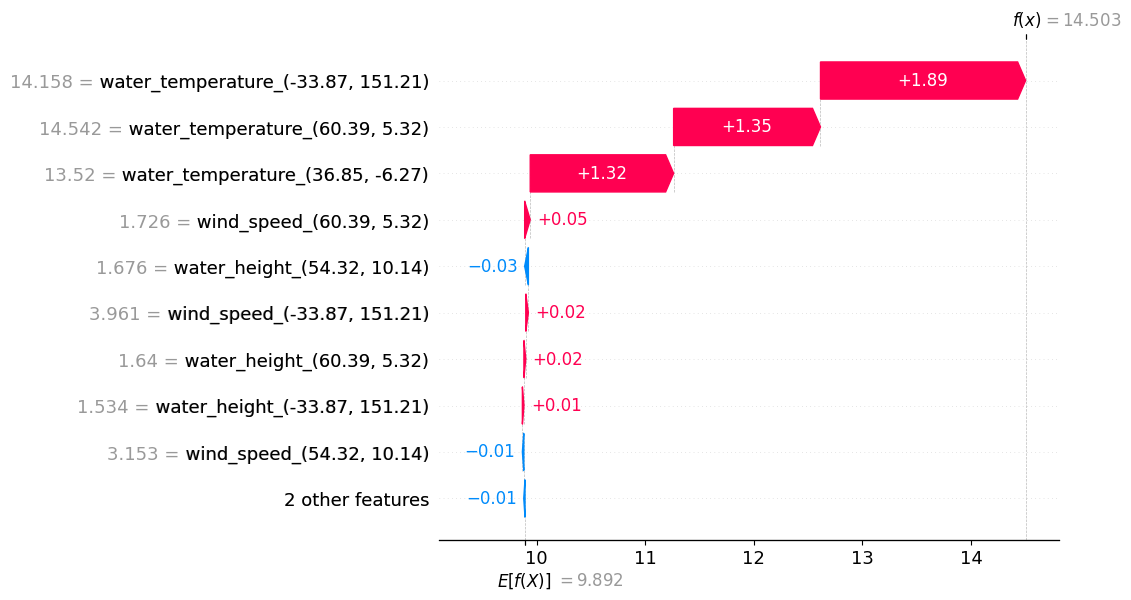

In [ ]:
# Wasserfall-Plot für ein Beispiel
shap.plots.waterfall(shap_values[0])

In [ ]:
import optuna.visualization as vis

# Verlauf der Optimierung (Zielwert pro Trial)
fig1 = vis.plot_optimization_history(study)
fig1.show()

# Wichtigkeit der Hyperparameter
fig2 = vis.plot_param_importances(study)
fig2.show()